In [1]:
import numpy as np
import sqlite3
import plotly.express as px
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from useful_functions_2 import *
from pdf2image import convert_from_path
from sklearn.manifold import TSNE
from scipy.spatial.distance import braycurtis
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist
from skbio.stats.distance import DistanceMatrix

### Parameters

In [2]:
standard_scale = False
sum_to_one = False
proportion_na = 0.1

### Import Data

In [3]:
tables_to_join = ["tPlantMicrobeGenus", "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
print(full_df.shape)
full_df = full_df.T.drop_duplicates().T

(43811, 15)


In [4]:
subdf = full_df.copy()

In [5]:
origin_pivoted_df = subdf.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='genera', values='relative_abundance')
origin_pivoted_df.shape
origin_pivoted_df.columns.name = None
origin_pivoted_df = origin_pivoted_df.reset_index()

In [6]:
origin_pivoted_df.shape

(167, 1448)

### Reduce Data to Most Common Taxa

In [7]:
df = origin_pivoted_df.copy()

In [8]:
df.head()

,sample_id,site_id,species,V2,Archaea|Euryarchaeota|Halobacteria|Halobacteriales|Haloarculaceae|Halapricum,Archaea|Euryarchaeota|Halobacteria|Halobacteriales|Halobacteriaceae|Halorussus,Archaea|Euryarchaeota|Halobacteria|Halobacteriales|Halococcaceae|Halococcus,Archaea|Euryarchaeota|Halobacteria|Haloferacales|Haloferacaceae|Halobellus,Archaea|Euryarchaeota|Halobacteria|Haloferacales|Haloferacaceae|Haloferax,Archaea|Euryarchaeota|Halobacteria|Haloferacales|Haloferacaceae|Halogeometricum,...,Eukaryota|Basidiomycota|Ustilaginomycetes|Ustilaginales|Ustilaginaceae|Ustilago,Eukaryota|Basidiomycota|Wallemiomycetes|Wallemiales|Wallemiaceae|Wallemia,Eukaryota|Chlorophyta|Mamiellophyceae|Mamiellales|Bathycoccaceae|Bathycoccus,Eukaryota|Chlorophyta|Mamiellophyceae|Mamiellales|Bathycoccaceae|Ostreococcus,Eukaryota|Chlorophyta|Mamiellophyceae|Mamiellales|Mamiellaceae|Micromonas,Eukaryota|Chlorophyta|Trebouxiophyceae|Chlorellales|Chlorellaceae|Chlorella,Eukaryota|Chlorophyta|Trebouxiophyceae|Chlorellales|Chlorellaceae|Prototheca,Eukaryota|Mucoromycota|Mortierellomycetes|Mortierellales|Mortierellaceae|Mortierella,Eukaryota|Mucoromycota|Mucoromycetes|Mucorales|Rhizopodaceae|Rhizopus,Eukaryota|Mucoromycota|Umbelopsidomycetes|Umbelopsidales|Umbelopsidaceae|Umbelopsis
0,CMB10,CMB,syriaca,0.999777,0.03005,NaN,0.016,NaN,NaN,NaN,...,0.00013,NaN,NaN,NaN,NaN,NaN,0.00014,0.00011,NaN,NaN
1,CMB11,CMB,syriaca,1.000000,0.02488,NaN,0.00903,NaN,NaN,NaN,...,0.00021,NaN,0.00011,NaN,0.00011,NaN,0.00016,NaN,NaN,NaN
2,CMB13,CMB,syriaca,0.989131,0.02391,NaN,0.01344,NaN,NaN,NaN,...,0.00013,NaN,0.00026,NaN,0.00032,NaN,0.00017,0.00016,NaN,NaN
3,CMB14,CMB,syriaca,0.999992,0.02786,NaN,0.00968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00018,NaN,0.00021,NaN,NaN,NaN
4,CMB15,CMB,syriaca,0.998548,0.00774,NaN,0.00315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
info_cols = ['sample_id', 'site_id', 'species', 'V2']

In [10]:
taxa_col = df.columns.drop(info_cols)

In [11]:
total_samples = len(df['sample_id'])

# common genera list
CGL = []

na_cutoff = proportion_na * total_samples

print(na_cutoff)

for taxa in taxa_col:
    if na_cutoff > df[taxa].isnull().sum():
        CGL.append(taxa)

CGL = CGL

16.7


In [12]:
df1 = df[CGL + info_cols]

In [13]:
df1 = df1.fillna(0)

### Add Broad Geographic Location Labels

In [14]:
df = df1
site_list = df['site_id']

df['BGR'] = site_list

df['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
df = df[df["BGR"].isin([0,1,2,3])]

df['BGR'] = df['BGR'].replace([0], 'Wintergreen')
df['BGR'] = df['BGR'].replace([1], 'Cole Mountain')
df['BGR'] = df['BGR'].replace([2], 'Blacksburg')
df['BGR'] = df['BGR'].replace([3], 'HR')

site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


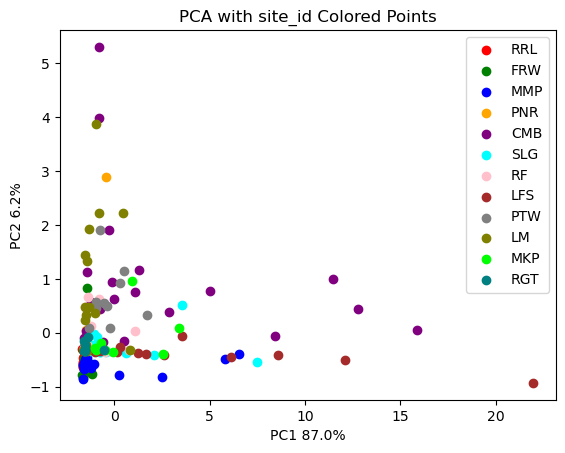

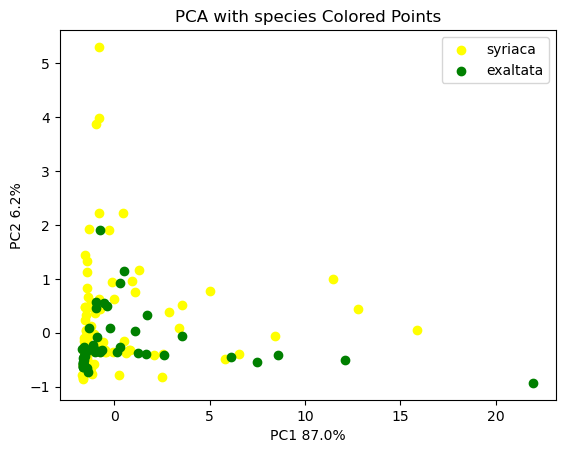

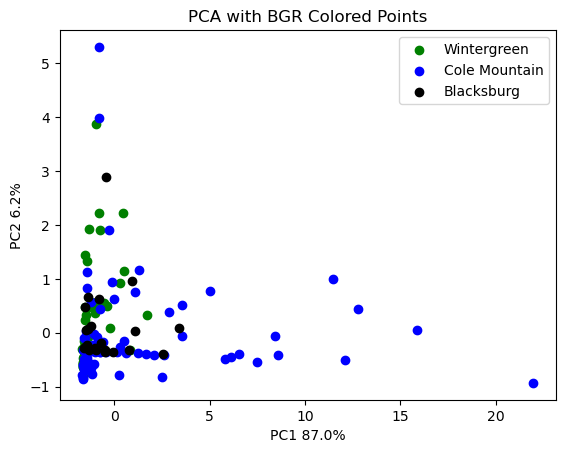

In [16]:
X = df[CGL]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    elif graph_type == 'BGR':
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    else:
        colors = {1: 'red', 2: 'blue'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('PCA of Field Sites and Leaf Microbiome')
        fig1 = fig
    elif graph_type == 'species':
        ax.set_title('PCA of Plant Species and Leaf Microbiome')
        fig2 = fig
    elif graph_type == 'BGR':
        ax.set_title('PCA of Broad Geographic Region and Leaf Microbiome')
        fig3 = fig
    else:
        ax.set_title('PCA of Run Id and Leaf Microbiome')
        fig3 = fig

In [19]:
df[CGL]

,Archaea|Euryarchaeota|Halobacteria|Halobacteriales|Haloarculaceae|Halapricum,Archaea|Euryarchaeota|Halobacteria|Halobacteriales|Halococcaceae|Halococcus,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Corynebacteriaceae|Corynebacterium,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Dietziaceae|Dietzia,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Mycobacteriaceae|Mycobacterium,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Mycobacteriaceae|Mycolicibacterium,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Nocardiaceae|Nocardia,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Nocardiaceae|Rhodococcus,Bacteria|Actinobacteria|Actinobacteria|Geodermatophilales|Geodermatophilaceae|Blastococcus,Bacteria|Actinobacteria|Actinobacteria|Micrococcales|Cellulomonadaceae|Cellulomonas,...,Bacteria|Proteobacteria|Gammaproteobacteria|Oceanospirillales|Halomonadaceae|Halomonas,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Proteobacteria|Gammaproteobacteria|Vibrionales|Vibrionaceae|Photobacterium,Bacteria|Proteobacteria|Gammaproteobacteria|Vibrionales|Vibrionaceae|Vibrio,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Xanthomonadaceae|Stenotrophomonas,Eukaryota|Ascomycota|Dothideomycetes|Dothideales|Saccotheciaceae|Aureobasidium,Eukaryota|Ascomycota|Dothideomycetes|Pleosporales|Didymellaceae|Epicoccum,Eukaryota|Ascomycota|Dothideomycetes|Pleosporales|Pleosporaceae|Alternaria,Eukaryota|Basidiomycota|Tremellomycetes|Tremellales|Bulleraceae|Bullera,Eukaryota|Basidiomycota|Tremellomycetes|Trichosporonales|Trichosporonaceae|Cutaneotrichosporon
0,0.03005,0.01600,0.00752,0.14157,0.02742,0.00049,0.00021,0.03102,0.02077,0.01154,...,0.00251,0.71969,0.00198,0.00045,0.02122,0.03273,0.01542,0.04427,0.07842,0.01305
1,0.02488,0.00903,0.01694,0.07565,0.00911,0.00561,0.00027,0.03087,0.01076,0.00584,...,0.00171,2.64833,0.00171,0.00044,0.01362,0.02464,0.01076,0.04288,0.10688,0.00667
2,0.02391,0.01344,0.01089,0.03660,0.01751,0.00645,0.00050,0.01027,0.01860,0.01098,...,0.00287,2.85174,0.00284,0.00059,0.00047,0.05852,0.02395,0.03700,0.09997,0.01042
3,0.02786,0.00968,0.00533,0.02183,0.00522,0.00455,0.00045,0.00921,0.01130,0.01433,...,0.00201,0.82043,0.00204,0.00033,0.00318,0.03540,0.00947,0.01676,0.06531,0.00562
4,0.00774,0.00315,0.00593,0.00906,0.00368,0.00165,0.00017,0.02016,0.00620,0.02303,...,0.01749,13.04768,0.00048,0.00000,0.03483,0.01116,0.00202,0.00766,0.05997,0.00265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.01392,0.00571,0.01040,0.07903,0.00547,0.00075,0.00000,0.00425,0.00063,0.00611,...,0.00064,0.85790,0.00228,0.00017,0.00042,0.00119,0.00087,0.00440,0.00302,0.00101
163,0.00866,0.00543,0.01038,0.02365,0.00543,0.00274,0.00022,0.00333,0.00137,0.00555,...,0.00000,0.95621,0.00122,0.00018,0.00071,0.00203,0.00076,0.00324,0.00509,0.00132
164,0.01969,0.00849,0.00144,0.06532,0.00413,0.00019,0.00011,0.00399,0.00126,0.01666,...,0.00184,0.51622,0.00230,0.00034,0.00041,0.00107,0.00050,0.00111,0.00637,0.00078
165,0.01434,0.00694,0.00014,0.03804,0.00790,0.00175,0.00053,0.02095,0.00044,0.00824,...,0.00011,9.07799,0.00145,0.00022,0.12159,0.00097,0.01576,0.05596,0.00162,0.00055


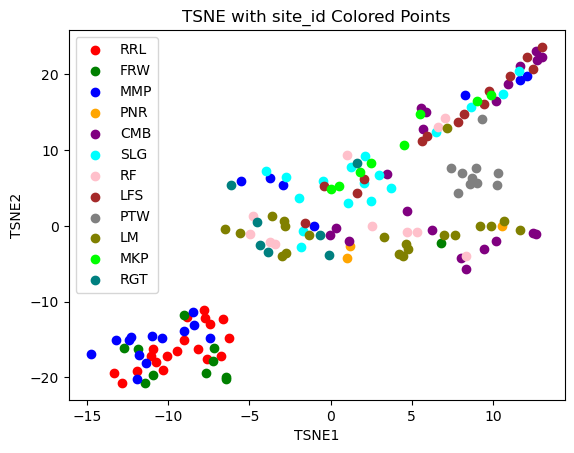

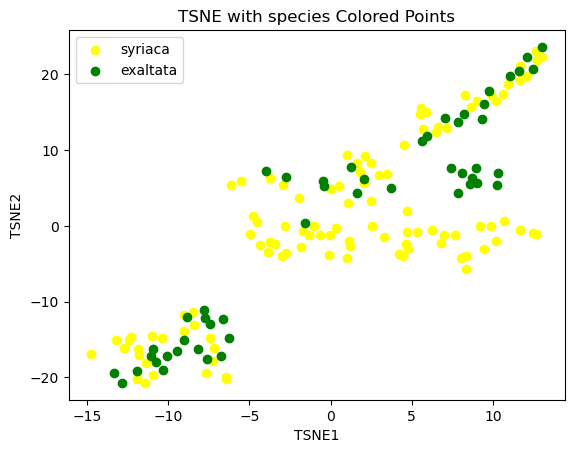

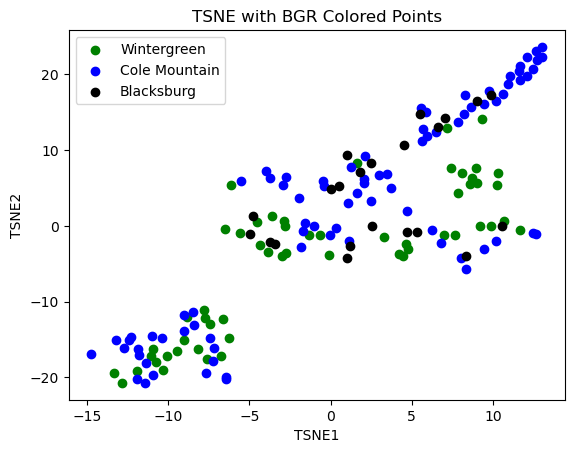

In [18]:
perplexity_value = 20 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=126)
tsne_transformed = tsne.fit_transform(df[CGL])


for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    elif graph_type == 'BGR':
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    else:
        colors = {1: 'red', 2: 'blue'}
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Field Site and Leaf Microbiome, P.V. = ' + str(perplexity_value))
        fig4 = fig
    elif graph_type == 'species':
        ax.set_title('TSNE of Species and Leaf Microbiome, P.V. = ' + str(perplexity_value))
        fig5 = fig
    elif graph_type == 'BGR':
        ax.set_title('TSNE of Broad Geographic Region and Leaf Microbiome')
        fig3 = fig
    else:
        ax.set_title('TSNE of Run Id and Leaf Microbiome')
        fig3 = fig